In [89]:
import numpy as np
import umap
from sklearn.datasets import load_iris, load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

pd.options.mode.use_inf_as_na = True

n_test_samples = 10000

def load_data(path, n_test_samples, extragalactic_only=True):
    meta = pd.read_feather('../input/meta_exp41.f') # features to use
    if extragalactic_only:
        meta = meta[~meta.distmod.isnull()] # use extragalactic data only
    meta_train = meta[~meta.target.isnull()]
    meta_train['target'] = 'class_' + meta_train['target'].astype(np.int32).astype(str)

    meta_test = meta[meta.target.isnull()].sample(n_test_samples)
    meta_test['target'] = 'test data'

    meta = pd.concat([meta_train, meta_test]).reset_index(drop=True)
    print('Using {} training samples + {} test samples.'.format(len(meta_train), len(meta_test)))

    target = meta['target']
    object_ids = meta['object_id']
    meta.drop(['object_id','target'],axis=1,inplace=True)
    cols = meta.columns
    
    print('preprocessing...')
    for c in tqdm(meta.columns):
        meta[c].fillna(meta[c].mean(), inplace=True)
    scaler = StandardScaler()
    meta = scaler.fit_transform(meta)
    
    return pd.DataFrame(meta, columns=cols), target, object_ids

# UMAP embeddings from train + test data

In [90]:
meta, target, object_ids = load_data('../input/meta_exp41.f', n_test_samples) # features to use

C:\Users\noumi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using 5523 training samples + 10000 test samples.
preprocessing...


100%|██████████████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 2914.05it/s]


In [86]:
meta.head()

,hostgal_photoz_err,distmod,mwebv,mean(flux)_ch0,mean(flux)_ch1,mean(flux)_ch2,mean(flux)_ch3,mean(flux)_ch4,mean(flux)_ch5,max(flux)_ch0,...,sn_salt2_t0_err,sn_salt2_x0_err,sn_salt2_x1_err,sn_salt2_c_err,luminosity_est_diff_ch0,luminosity_est_diff_ch1,luminosity_est_diff_ch2,luminosity_est_diff_ch3,luminosity_est_diff_ch4,luminosity_est_diff_ch5
0,0.203184,1.866259,-0.593221,-0.015129,-0.067979,-0.121532,-0.123037,-0.129417,-0.159399,-0.018820,...,-0.184249,-9.749096e-03,-0.044878,-0.128835,-0.083318,-0.090676,-0.267097,-0.284158,-0.373268,-0.491222
1,-0.571301,-0.844121,-0.457022,-0.013347,-0.061638,-0.095790,-0.091204,-0.085725,-0.095813,-0.019919,...,-0.192981,-9.749096e-03,-0.045422,-0.136138,-0.176203,-0.236251,-0.378714,-0.380845,-0.441425,-0.556422
2,3.104188,-0.560463,-0.593221,-0.012116,-0.031176,-0.036890,-0.006954,-0.011697,-0.033500,-0.018371,...,0.000000,1.200913e-18,0.000000,0.000000,-0.159353,0.209772,0.065685,-0.046179,-0.172474,-0.421140
3,-0.565156,-0.759655,-0.427836,-0.012874,-0.037091,-0.032601,-0.032028,-0.038775,-0.072146,-0.019997,...,-0.194055,-9.749096e-03,-0.045485,-0.156206,-0.174489,-0.192674,-0.269088,-0.267044,-0.333413,-0.517110
4,-0.523764,-1.122095,-0.476479,-0.003387,0.191966,0.216067,0.137783,0.088770,0.078422,0.014715,...,-0.197346,-9.749096e-03,-0.045491,-0.159948,-0.128486,0.369963,0.091949,-0.091809,-0.273384,-0.458082


## Preprocessing Data (filling NA, Inf & normalizing)

In [87]:
import matplotlib as mpl

def plot(embedding, target, n_neighbors, min_dist, alpha=0.6, mask_classes=None, xrange=None, yrange=None, dot_size=4):  
    if mask_classes:
        tgt = ['class_{}'.format(c) for c in mask_classes] + ['test data']
        mask = [t in tgt for t in target]
        embedding = embedding[mask]
        target = target[mask].reset_index(drop=True)

    classes = list(target.unique())
    classes.remove('test data')
    classes+=['test data']

    lbl = {c:i for i,c in enumerate(classes)}
    labels = np.array([lbl[target[i]] for i in range(len(target))])
    

    cmap = mpl.colors.ListedColormap(['red', 'yellow', 'blue', 'orange', 'magenta', 'green', 'lightgreen', 'maroon', 'cyan', 'lightgray'])
   
    plt.figure(figsize=(30,20))
 
    plt.scatter(embedding[:, 0], embedding[:, 1], s=dot_size, c=labels, cmap=cmap, alpha=alpha)
    #plt.gca().set_aspect('equal', 'datalim')
    boundaries = np.arange(len(classes)+1)-0.5
    cbar = plt.colorbar(boundaries=boundaries)
    cbar.set_ticks(np.arange(len(classes)+1))
    cbar.set_ticklabels(classes)
        
    if xrange:
        plt.xlim(xrange)
    if yrange:
        plt.ylim(yrange)
       
    title = 'UMAP projection of the PLaSTiCC(n_neighbors:{},min_dist:{})'.format(n_neighbors,min_dist)
    if mask_classes is not None:
        title += ', Show only class {} + test'.format(mask_classes)
    plt.title(title, fontsize=24)

## Execute UMAP

C:\Users\noumi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


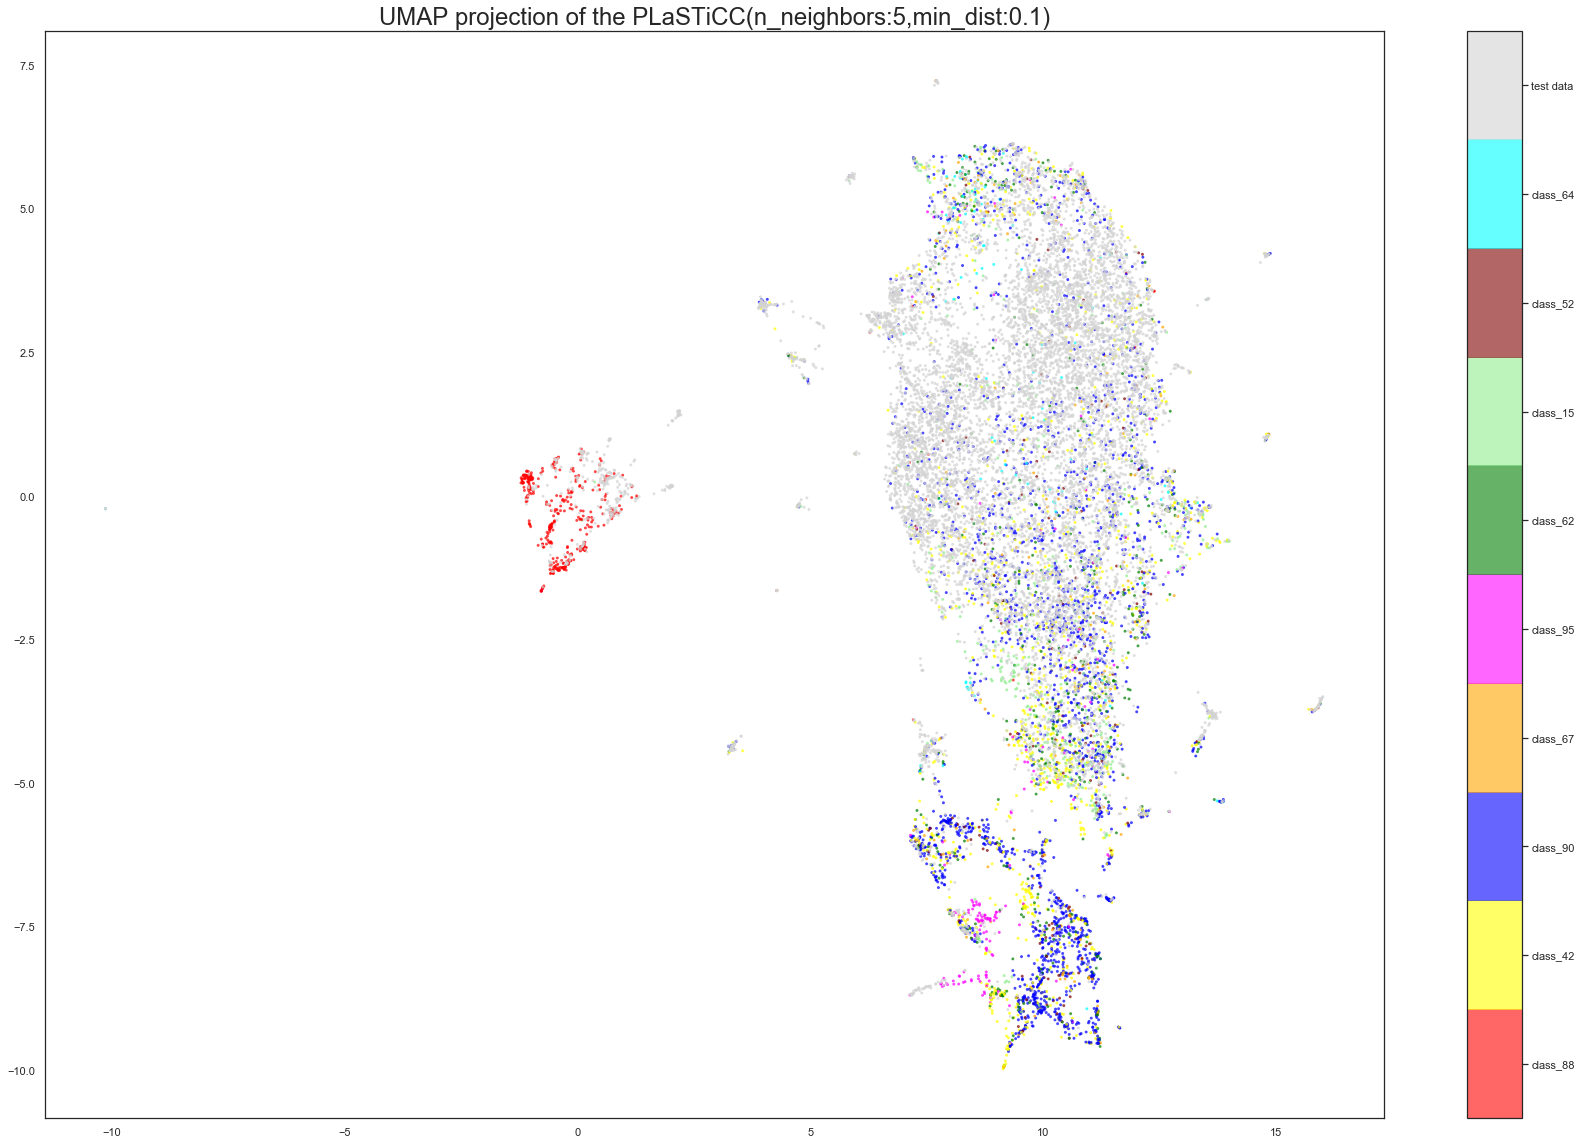

In [88]:
n_neighbors=5
min_dist=0.1
reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist)
embedding = reducer.fit_transform(meta)
plot(embedding, target, n_neighbors, min_dist)

Some interesting points I've found:
- **Train & test data are apparently different** - majority of training data (bottom right) don't belong to main cluster of test data (top right). It may explain why pseudo-labelling works (PL works as a data augmentation in the top right area)
- **There are few small clusters which contains small or no training data** - class 99 candidate? A mere error of UMAP itself?
- **There is a small drift between class88 vs class88-like test data (left)** - Are these test data class88? Or class99 which is similar to 88? (e.g. active galactic nuclei) 

Let's focus on particular class vs test data.

## Class90 (SNIa) vs Test 

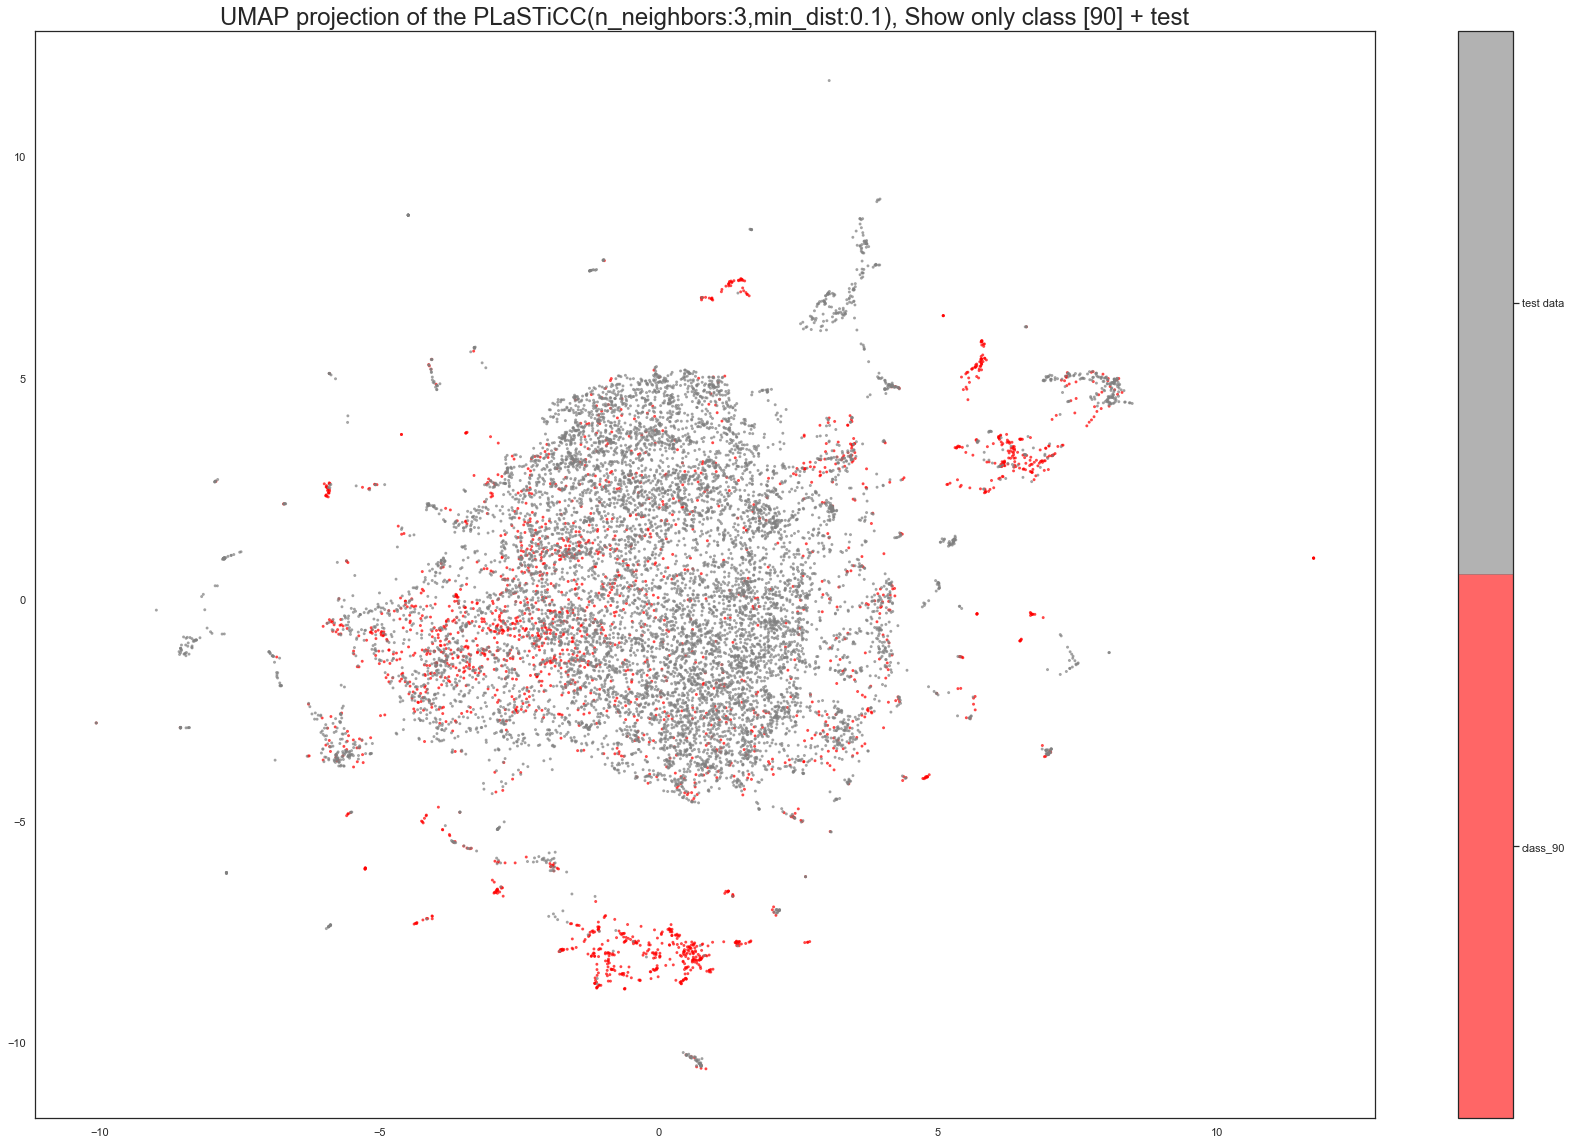

In [40]:
plot(embedding, target, n_neighbors, min_dist, mask_classes=[90])

## Class88 (Strong Gravitational Lens) vs Test 

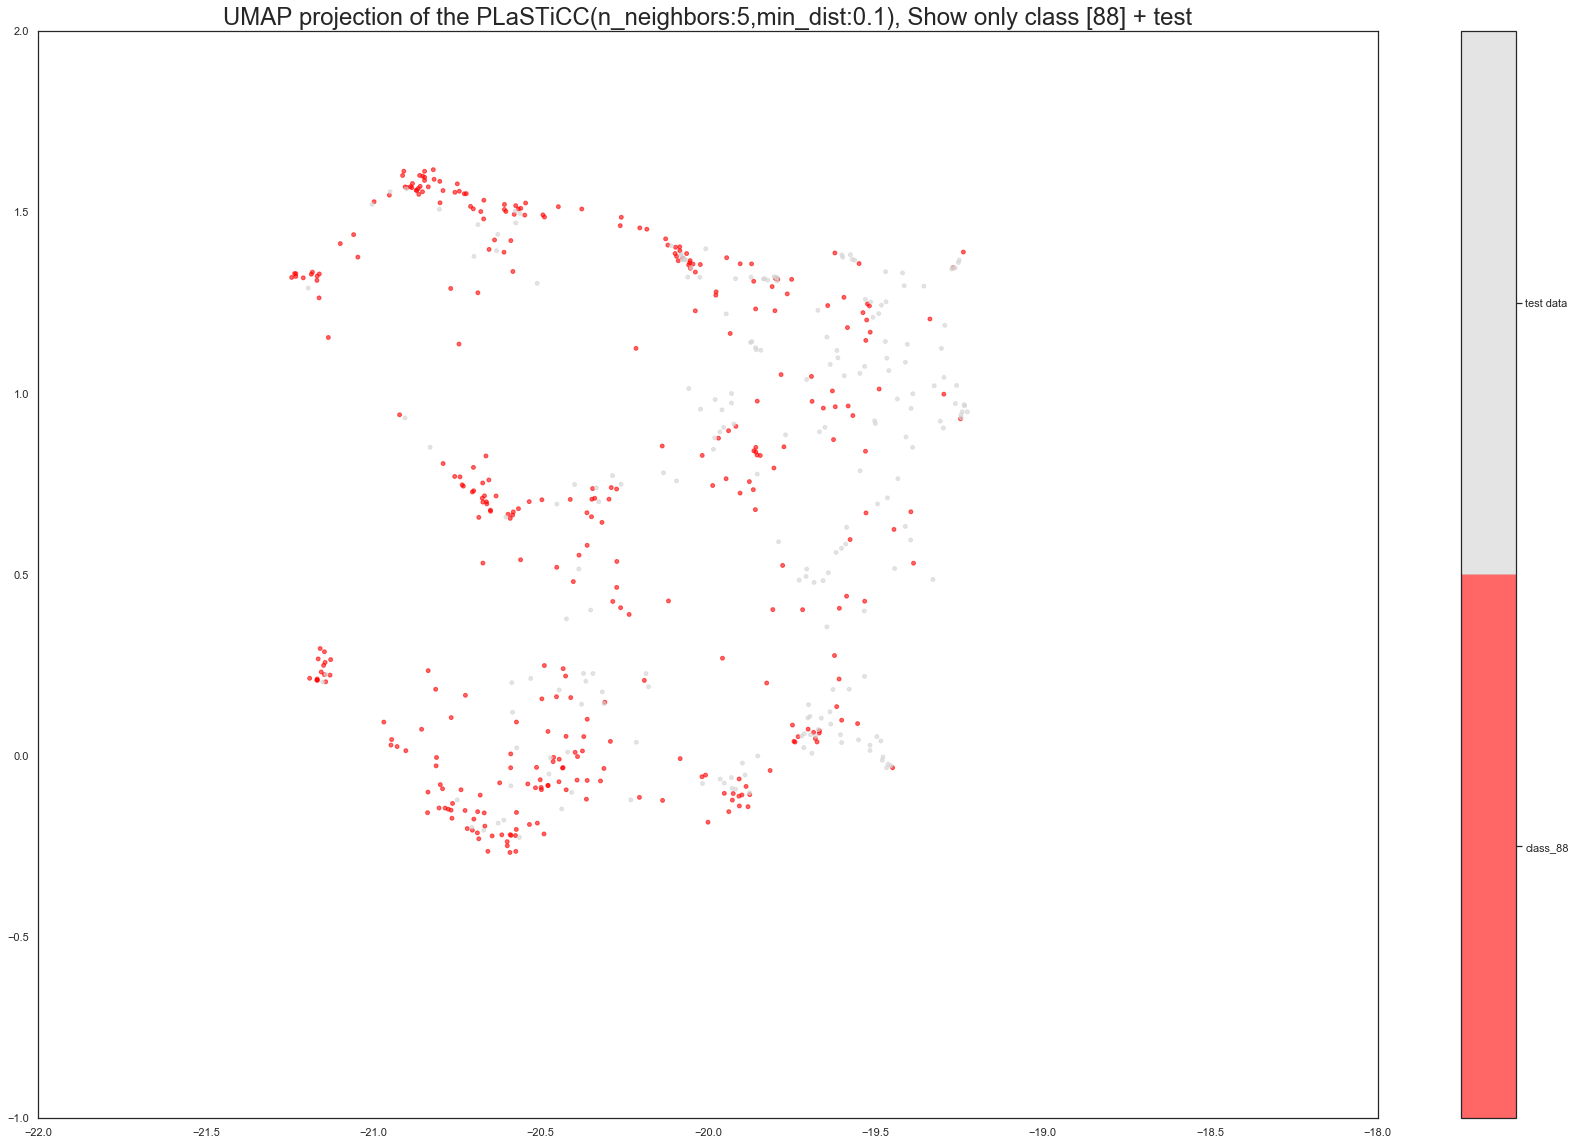

In [27]:
plot(embedding, target, n_neighbors, min_dist, mask_classes=[88], xrange=(-22,-18), yrange=(-1,2), dot_size=15)

## Class52+62 (SNIb/c? hard classes) vs Test 

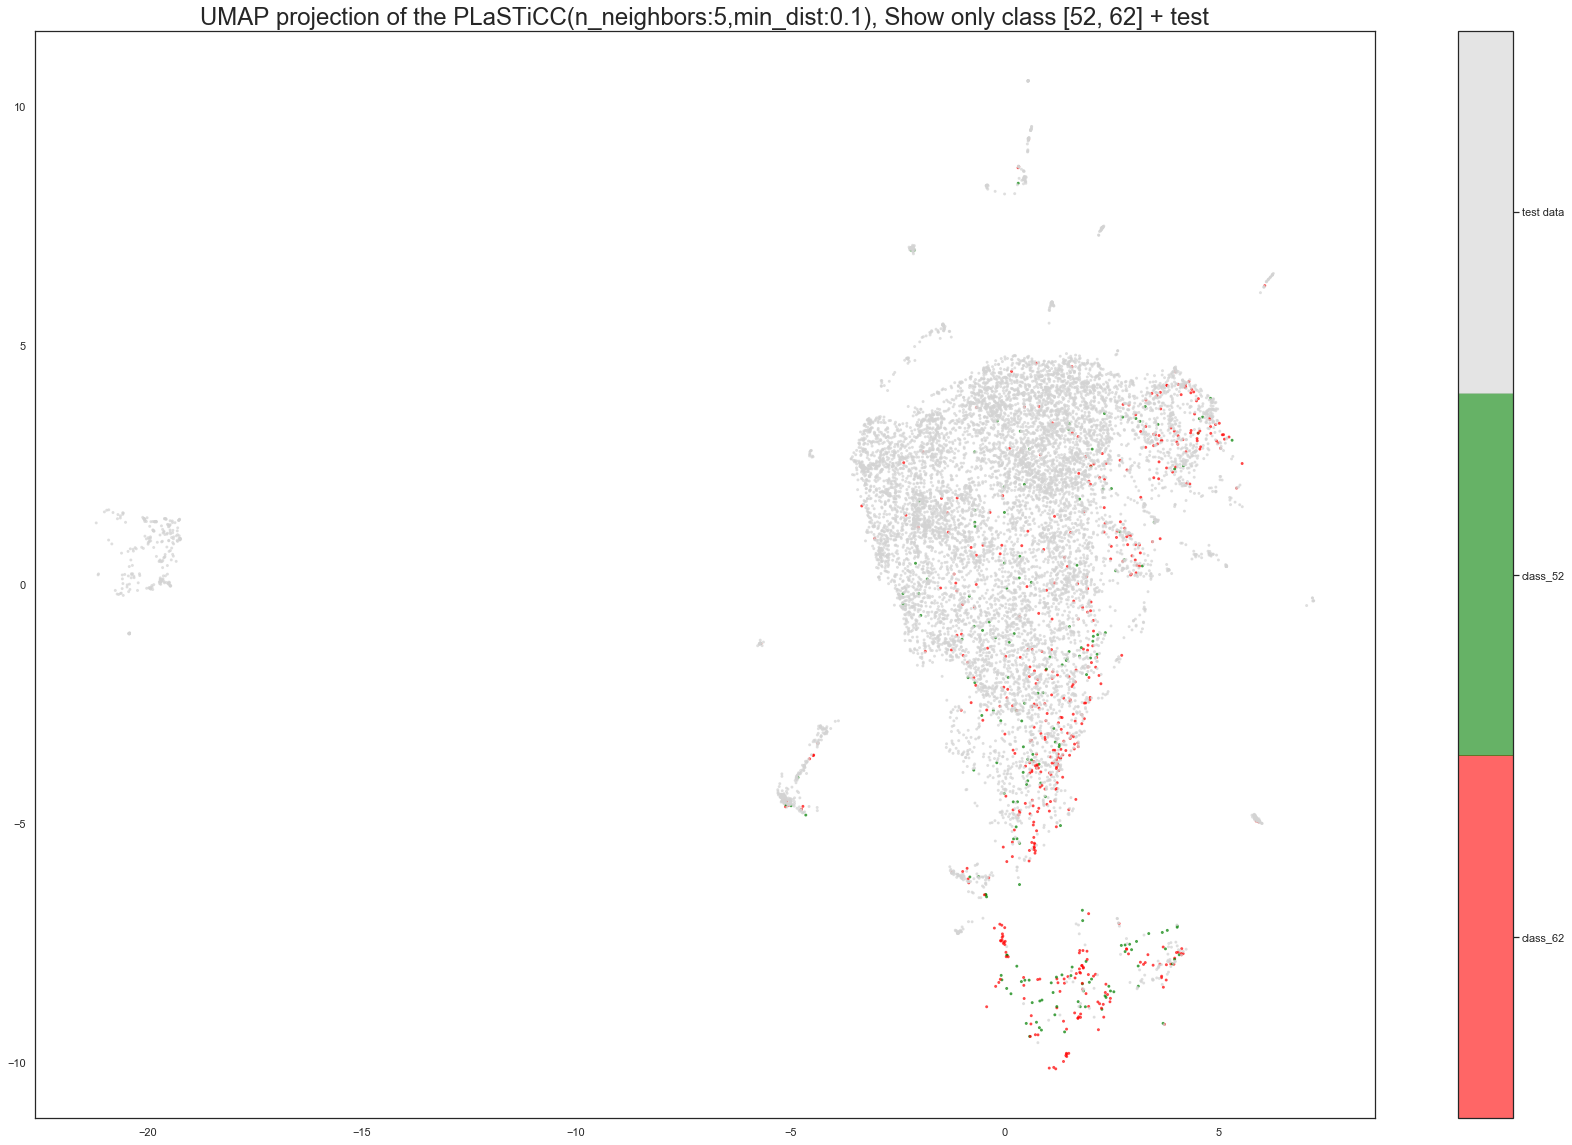

In [31]:
plot(embedding, target, n_neighbors, min_dist, mask_classes=[52,62])

## UMAP with different hyperparameters

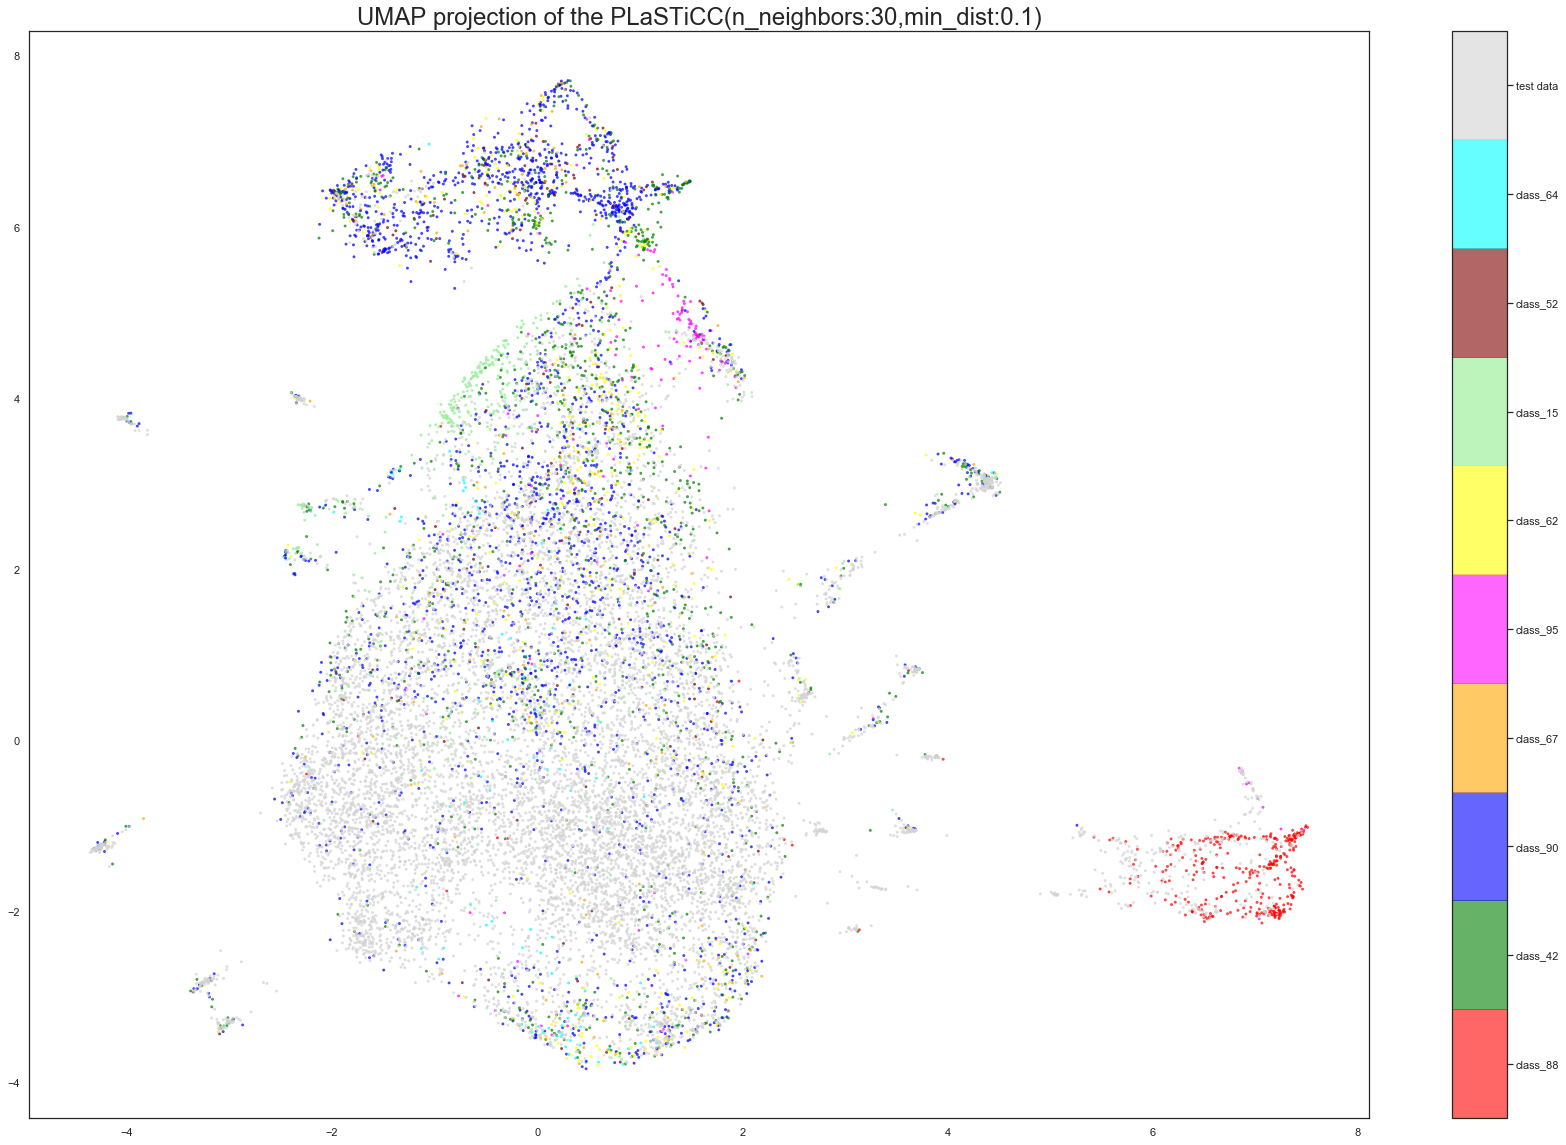

In [12]:
n_neighbors=30
min_dist=0.1
reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist)
embedding = reducer.fit_transform(meta)
plot(embedding, target, n_neighbors, min_dist)

C:\Users\noumi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 5 separate connected components using meta-embedding (experimental)
  n_components
C:\Users\noumi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\manifold\spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


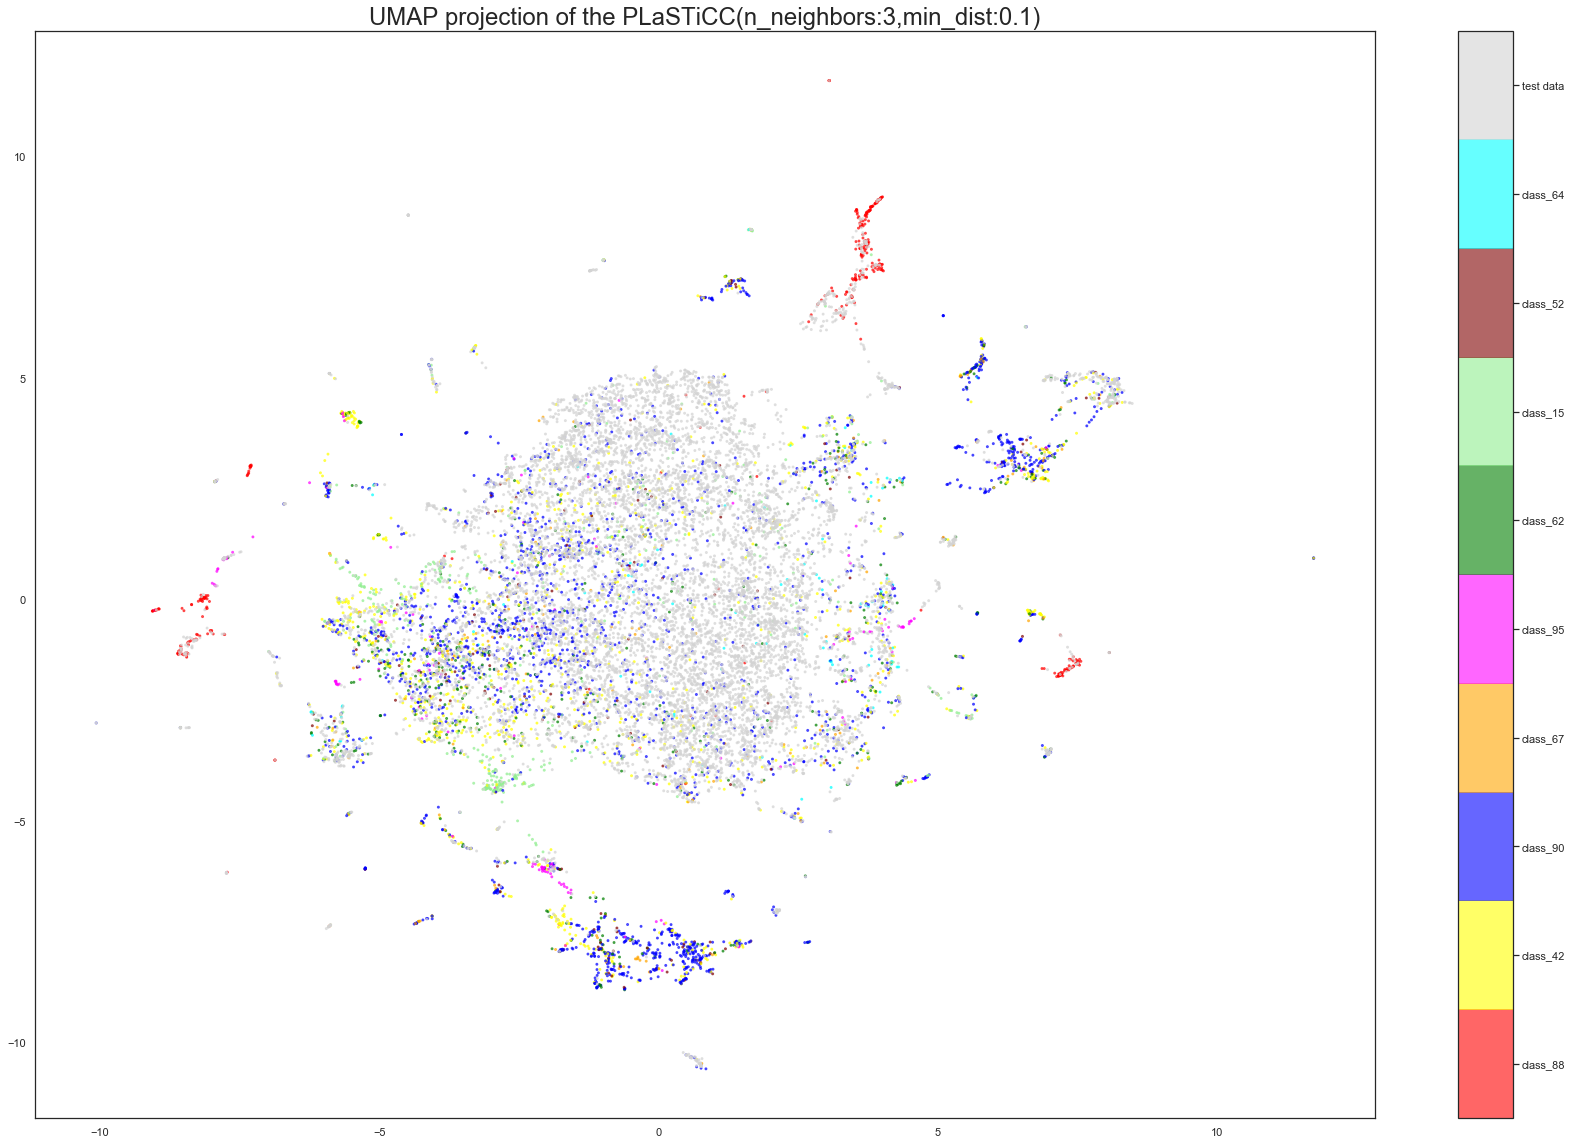

In [32]:
n_neighbors=3
min_dist=0.1
reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist)
embedding = reducer.fit_transform(meta)
plot(embedding, target, n_neighbors, min_dist)

## Pseudo Label vs Real Label
Show pseudo-label used in my best single model (experiment41)

In [72]:
pl = pd.read_feather('../experiment41/nyanp_pseudo_label_exp41.f')
target_ = target.copy()
target_.loc[object_ids.isin(pl[pl.target == 42].object_id)] = 'class_42-pseudo'
target_.loc[object_ids.isin(pl[pl.target == 90].object_id)] = 'class_90-pseudo'

## class 90

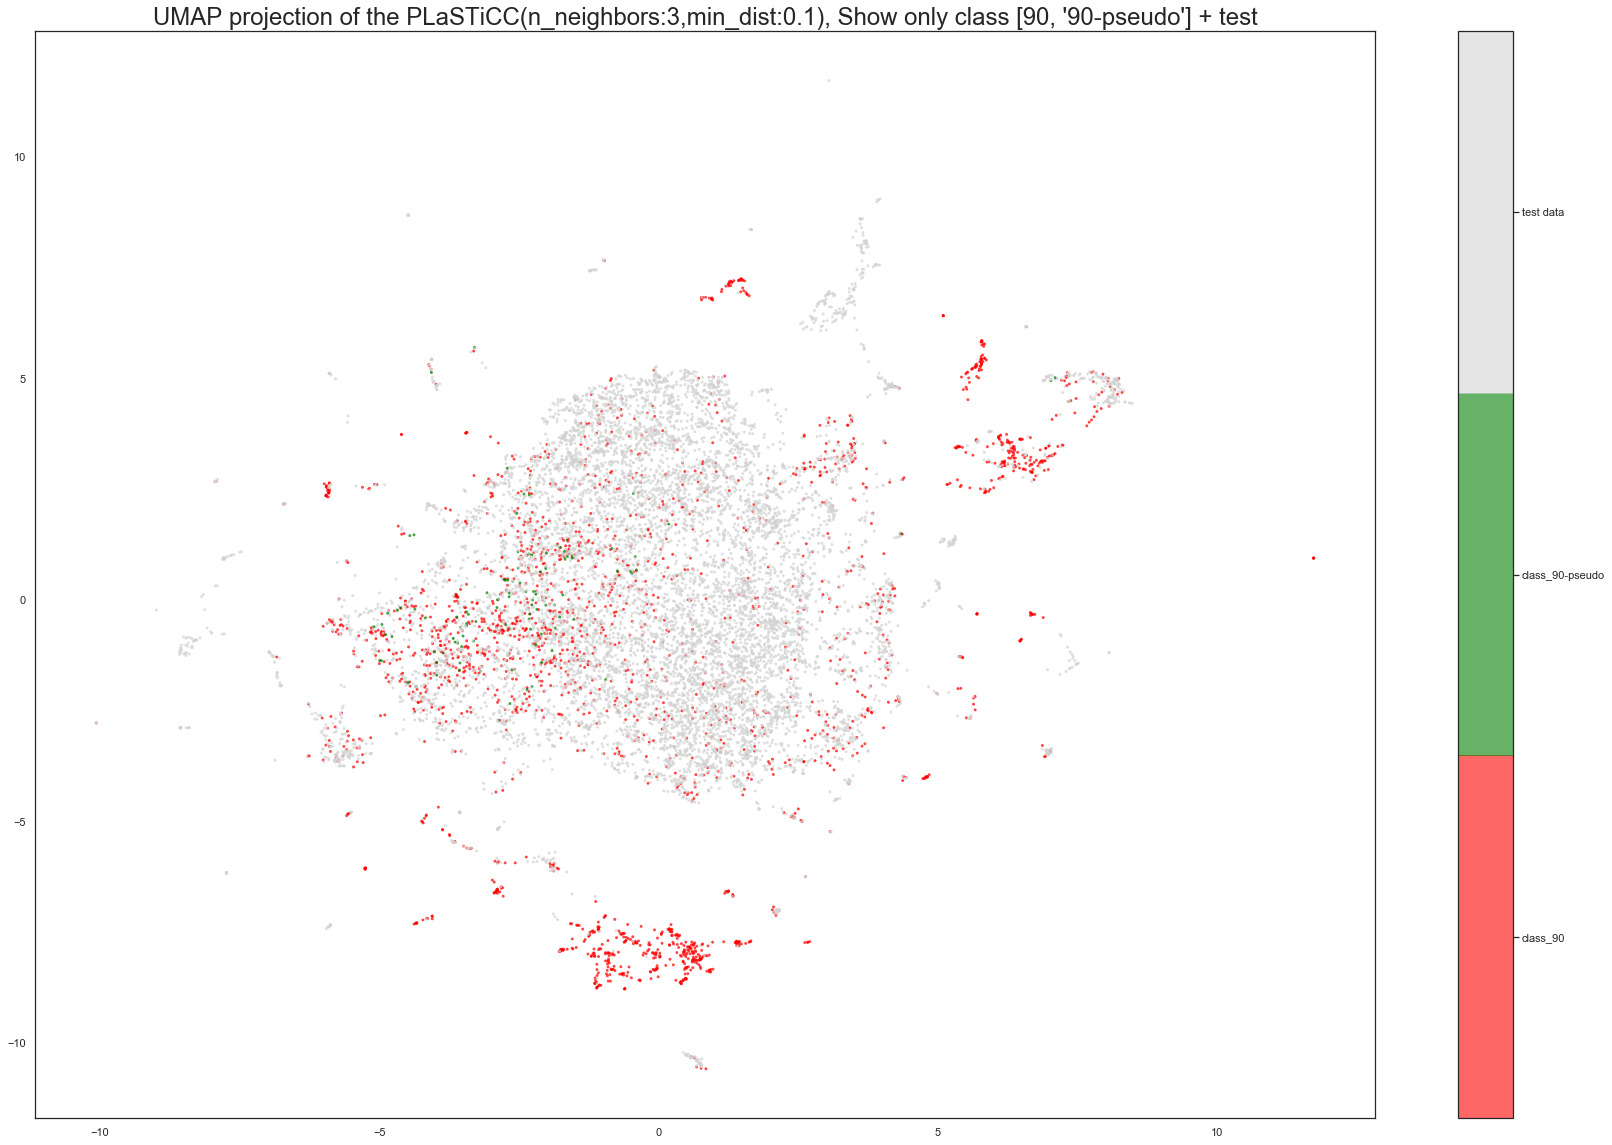

In [73]:
plot(embedding, target_, n_neighbors, min_dist, mask_classes=[90,'90-pseudo'])

## class 42

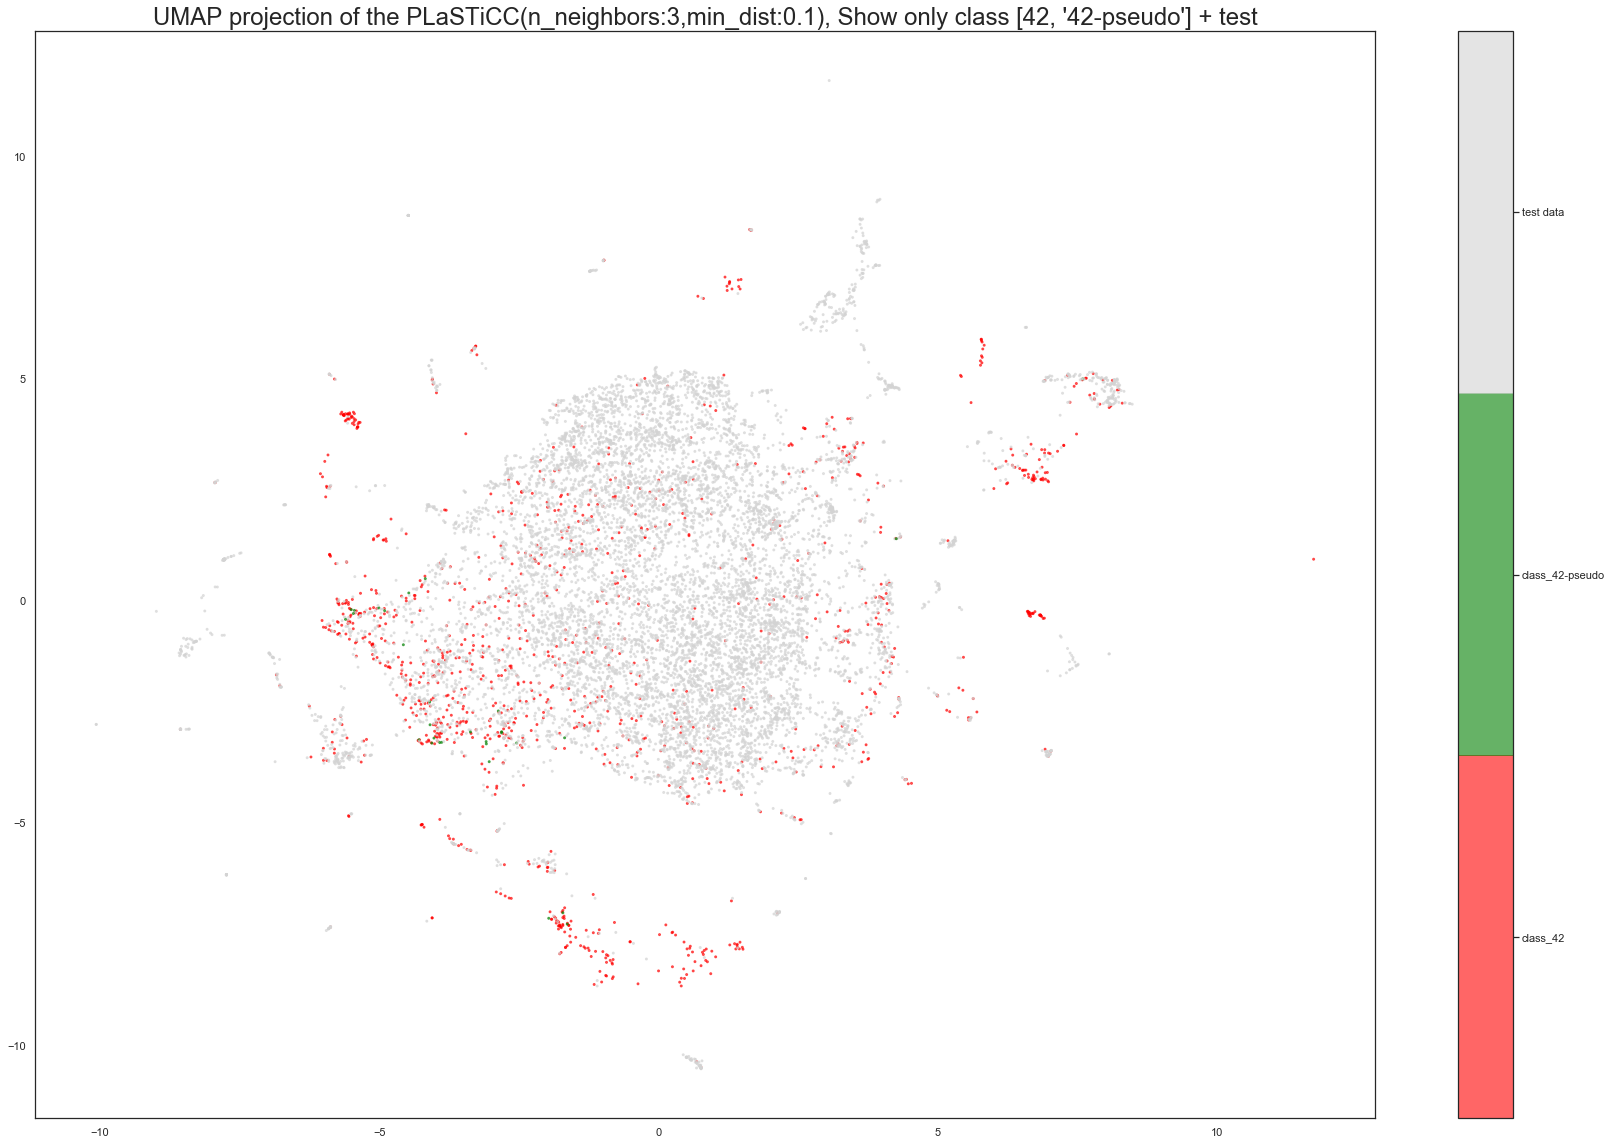

In [76]:
plot(embedding, target_, n_neighbors, min_dist, mask_classes=[42,'42-pseudo'])

## Semi-supervised UMAP

C:\Users\noumi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using 5523 training samples + 100000 test samples.
preprocessing...


100%|██████████████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 1065.70it/s]


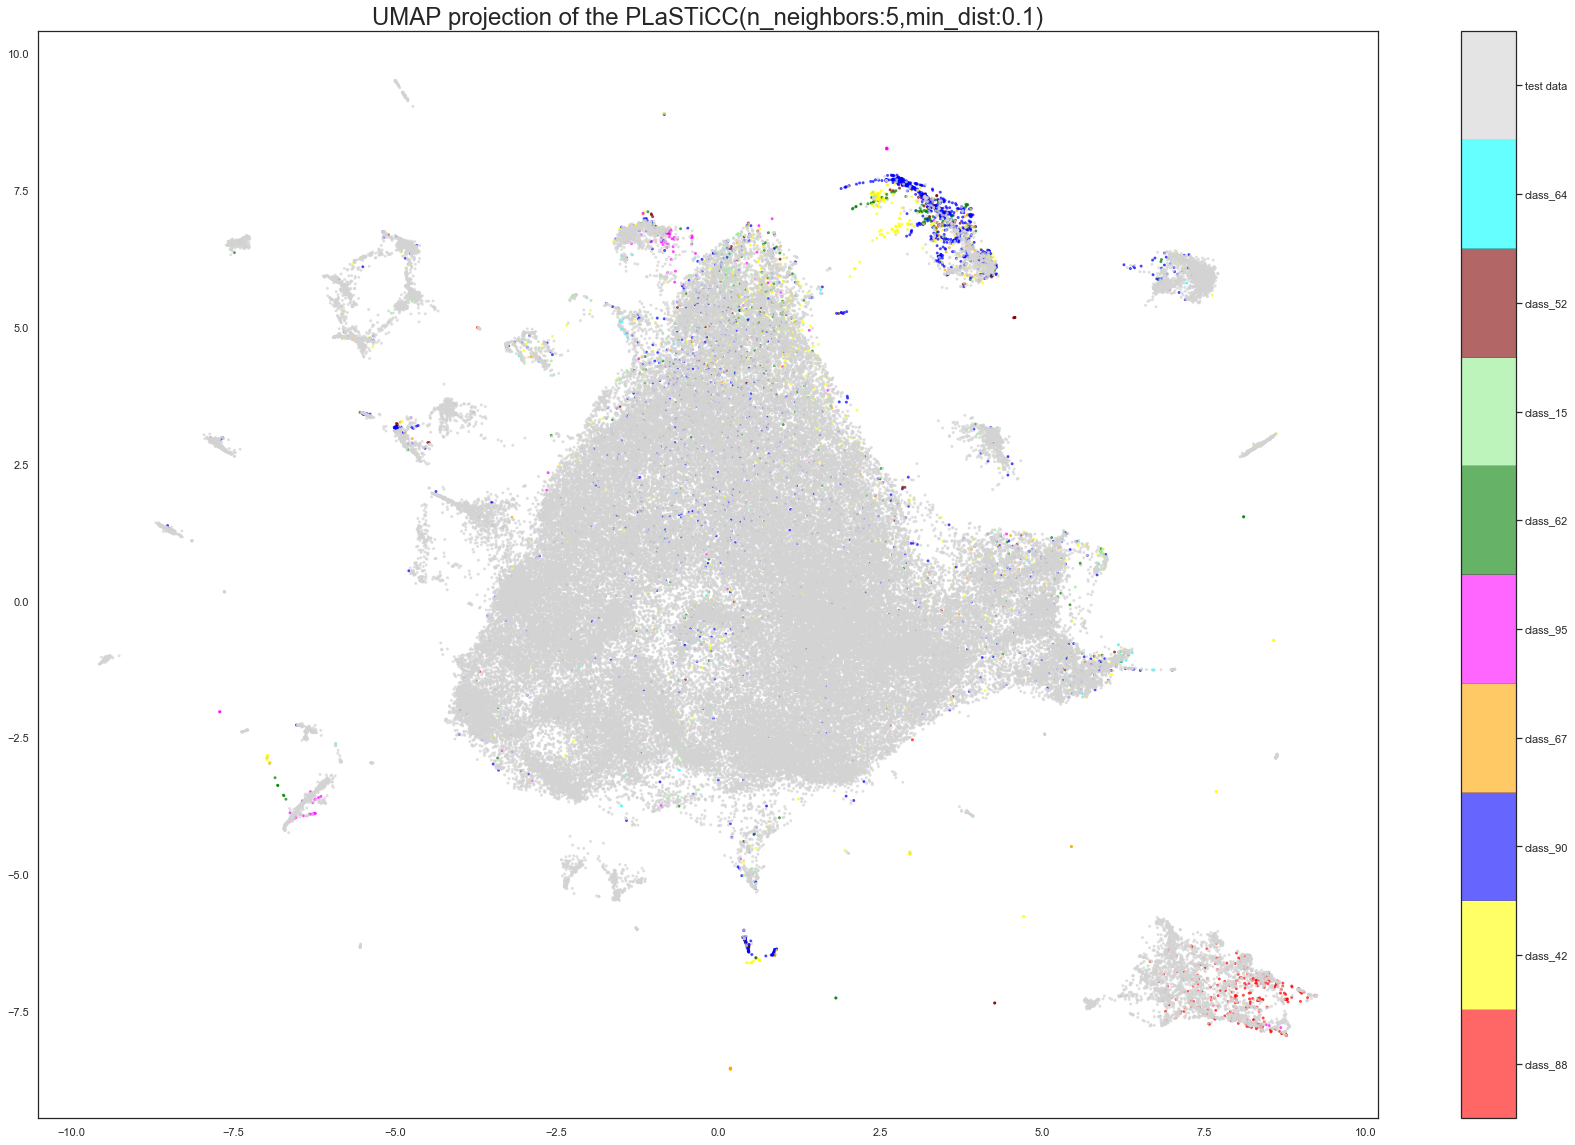

In [91]:
meta2, target2, _ = load_data('../input/meta_exp41.f', 100000) # features to use

target2int = {t: i for i, t in enumerate(target2.unique())}
target2int['test data'] = -1

n_neighbors=5
min_dist=0.1
reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist)

embedding2 = reducer.fit_transform(meta2, y=[target2int[t] for t in target2])
plot(embedding2, target2, n_neighbors, min_dist)

It's hard to understand. At least there are clear separation between class88 (right bottom, gravitational lens), class95 (top center, hypernova), and class 90/42/62 (supernova family).